In [1]:
from utils.data import Dataset
from utils.conllu import read_conllu_dataset
import numpy as np

In [2]:
dataset = Dataset()

train_sentences = read_conllu_dataset("data/ro_rrt-ud-train.conllu")
test_sentences = read_conllu_dataset("data/ro_rrt-ud-test.conllu")

# Fit on training data
X_train, y_train = dataset.fit(train_sentences, mode="chars")

# Encode test data (fixed shape)
X_test, y_test = dataset.encode(test_sentences)

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8043, 163, 55), (8043, 163, 17), (729, 163, 55), (729, 163, 17))

In [4]:
import tensorflow as tf

In [5]:
_, seq_len, char_feat_len = X_train.shape
output_dim = y_train.shape[-1]

In [6]:
sample_weight = np.where(np.argmax(y_train, axis=-1) != 0, 1.0, 0.0)

In [7]:
input_layer = tf.keras.layers.Input(shape=(seq_len, char_feat_len))
#lstm = tf.keras.layers.LSTM(256, return_sequences=True)(input_layer)
x = tf.keras.layers.Conv1D(64, kernel_size=(11,), padding="same")(input_layer)
x = tf.keras.layers.Conv1D(128, kernel_size=(7,), padding="same")(x)
x = tf.keras.layers.Conv1D(256, kernel_size=(3,), padding="same")(x)
output_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_dim, activation='softmax'))(x)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', weighted_metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 163, 55)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 163, 64)        │        38,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 163, 128)       │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 163, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 163, 17)        │         4,369 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,185 (778.07 KB)

 Trainable params: 199,185 (778.07 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    sample_weight = sample_weight
)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 110s 834ms/step - accuracy: 0.3932 - loss: 0.4609 - val_accuracy: 0.5378 - val_loss: 0.2121
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 825ms/step - accuracy: 0.5109 - loss: 0.2023 - val_accuracy: 0.5315 - val_loss: 0.2120
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 97s 849ms/step - accuracy: 0.5172 - loss: 0.1989 - val_accuracy: 0.5152 - val_loss: 0.2191
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 139s 825ms/step - accuracy: 0.5189 - loss: 0.2008 - val_accuracy: 0.5522 - val_loss: 0.2047
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 97s 850ms/step - accuracy: 0.5234 - loss: 0.1977 - val_accuracy: 0.5486 - val_loss: 0.2040
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 96s 843ms/step - accuracy: 0.5291 - loss: 0.1970 - val_accuracy: 0.5376 - val_loss: 0.2089
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 826ms/step - accuracy: 0.5287 - loss: 0.1928 - val_accuracy: 0.5395 - val_loss: 0.2088
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 94s 828ms/step - accuracy: 0.5318 - loss:

In [9]:
import matplotlib.pyplot as plt

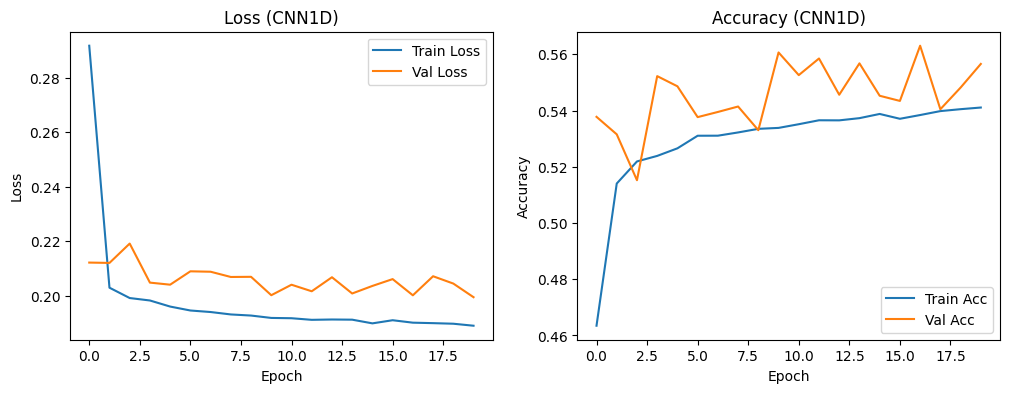

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss (CNN1D)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy (CNN1D)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
model.save('pos_cnn1d_model.keras')

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test, sample_weight=np.where(np.argmax(y_test, axis=-1) != 0, 1.0, 0.0))
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5283 - loss: 0.1887

Test Loss: 0.1869 | Test Accuracy: 0.5373


In [13]:
import numpy as np
y_pred = model.predict(X_test)
y_pred_ids = np.argmax(y_pred, axis=-1)
y_true_ids = np.argmax(y_test, axis=-1)

# Reverse label index
idx2label = {i: l for l, i in dataset.label2id.items()}

# Show sample predictions
for i in range(3):
    print(f"\n--- Sentence {i+1} ---")
    for j in range(seq_len):
        word_vec = X_test[i, j]
        if np.all(word_vec == 0): continue  # padding

        pred_label = idx2label.get(y_pred_ids[i, j]-1, "UNK")
        true_label = idx2label.get(y_true_ids[i, j]-1, "UNK")
        print(f"{j:2}: Pred: {pred_label:6} | True: {true_label}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step

--- Sentence 1 ---
 0: Pred: INTJ   | True: INTJ
 1: Pred: PART   | True: PART
 2: Pred: PART   | True: SCONJ
 3: Pred: SCONJ  | True: SCONJ
 4: Pred: PART   | True: ADP
 5: Pred: PART   | True: PART
 6: Pred: PROPN  | True: ADV
 7: Pred: PART   | True: SCONJ
 8: Pred: ADJ    | True: ADJ
 9: Pred: INTJ   | True: INTJ
10: Pred: PROPN  | True: PROPN

--- Sentence 2 ---
 0: Pred: ADJ    | True: ADJ
 1: Pred: INTJ   | True: INTJ
 2: Pred: INTJ   | True: PART
 3: Pred: ADP    | True: SCONJ
 4: Pred: CCONJ  | True: CCONJ
 5: Pred: INTJ   | True: INTJ
 6: Pred: ADJ    | True: ADJ
 7: Pred: SCONJ  | True: INTJ
 8: Pred: ADJ    | True: <PAD>
 9: Pred: CCONJ  | True: ADJ
10: Pred: INTJ   | True: INTJ
11: Pred: AUX    | True: AUX
12: Pred: ADJ    | True: CCONJ
13: Pred: INTJ   | True: INTJ
14: Pred: SCONJ  | True: PART
15: Pred: ADJ    | True: PART
16: Pred: INTJ   | True: SCONJ
17: Pred: INTJ   | True: ADJ
18: Pred: ADJ    | True: PART
19: Pred: PROPN  |

In [14]:
np.argmax(y_test, axis=-1)[0]

array([ 8, 11, 15, 15,  3, 11,  4, 15,  2,  8, 13,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [15]:
y_true_flat = y_true_ids.reshape((-1,))
y_pred_flat = y_pred_ids.reshape((-1,))
mask = (y_true_flat != 0)
y_true_flat = y_true_flat[mask]
y_pred_flat = y_pred_flat[mask]

np.max(y_true_flat), np.min(y_true_flat), np.max(y_pred_flat), np.min(y_pred_flat)

np.sum(y_true_flat==7), np.sum(y_pred_flat==7)


(np.int64(6), np.int64(0))

Classification Report:
              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00         0
         ADJ       0.38      0.34      0.36      1172
         ADP       0.55      0.81      0.66      2333
         ADV       0.24      0.04      0.06       650
         AUX       0.41      0.29      0.34       618
       CCONJ       0.75      0.37      0.49       471
         DET       0.33      0.16      0.21       898
        INTJ       0.00      0.00      0.00         6
        NOUN       0.52      0.69      0.60      4042
         NUM       0.68      0.55      0.60       456
        PART       0.38      0.20      0.26       358
        PRON       0.23      0.23      0.23       862
       PROPN       0.58      0.55      0.57       455
       PUNCT       0.85      0.94      0.89      2083
       SCONJ       0.55      0.04      0.07       154
        VERB       0.37      0.24      0.30      1749
           X       0.56      0.29      0.38        17

   

d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resul

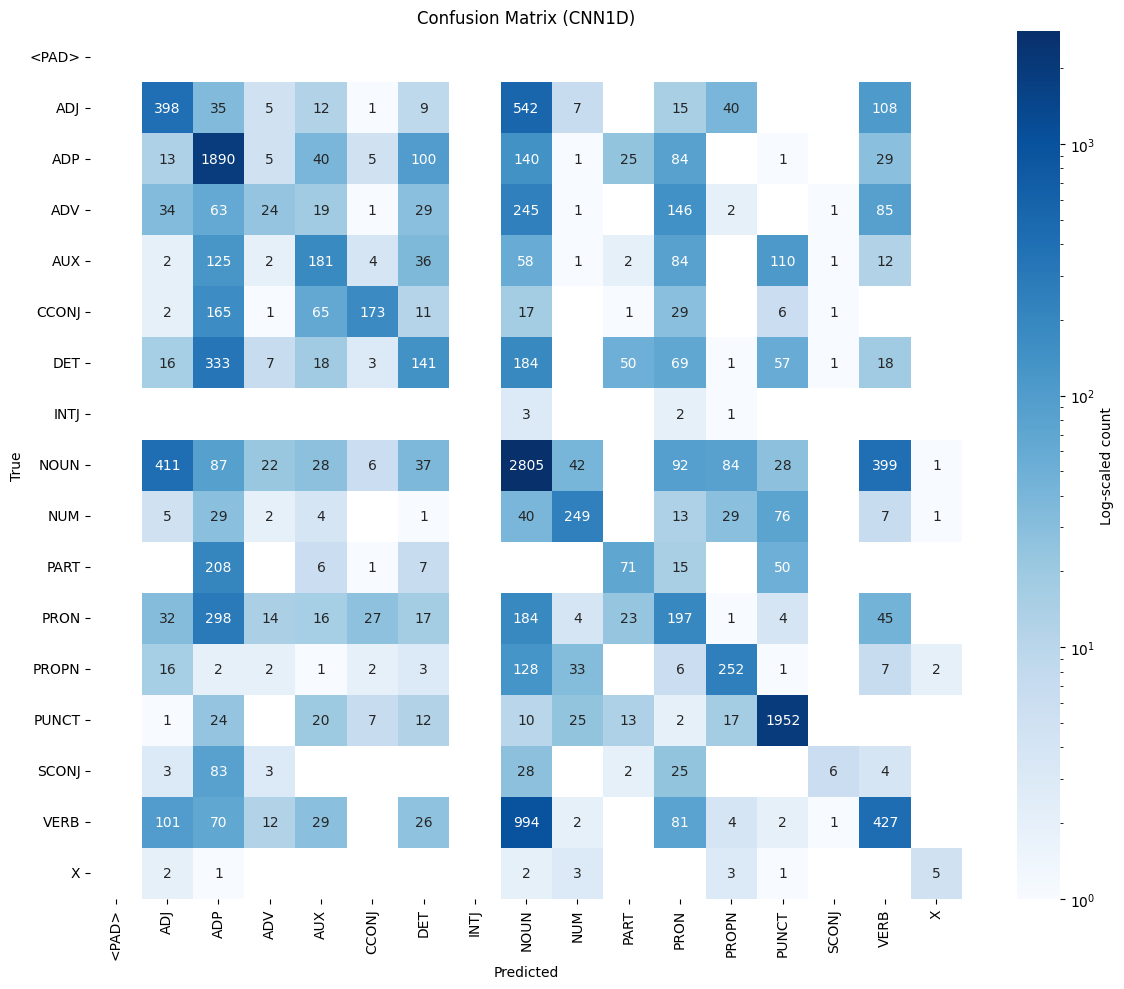

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.colors import LogNorm

# Compute confusion matrix
labels = dataset.labels
label_ids = list(range(len(labels)))

print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, labels=label_ids, target_names=labels))

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=label_ids)

# Plot with log scale
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', norm=LogNorm(vmin=1, vmax=cm.max()),
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Log-scaled count'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (CNN1D)")
plt.tight_layout()
plt.show()
